# Define custom image transforms

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
from pathlib import Path
from typing import Any, Dict

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torchvision.transforms as _transforms
import torchvision.transforms.functional as F
import torchvision.transforms.v2 as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Transform
from torchvision.utils import make_grid

from src.modules.images.timm_pretrained import CNNEncoder
from src.modules.transforms import NormalizeBeforeCrop, SimpleTransform, SimpleWithNormalize
from src.modules.transforms.fill_nans import FillNaNs
from src.utils.io import load_image_paths_to_array

plt.rcParams["savefig.bbox"] = "tight"

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

In [3]:
def show(imgs, figsize=(10, 10)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

Mounting cpjump1...
Mounting cpjump2...
Mounting cpjump3...


In [5]:
image_path = "../cpjump1/jump/images/source_9/20210831-Run7/GR00003330"

In [6]:
default_channels = ["DNA", "AGP", "ER", "Mito", "RNA"]

In [7]:
possible_files = glob(f"{image_path}/*DNA.png")

In [8]:
class SimpleDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.possible_files = glob(f"{image_path}/*DNA.png")
        self.channels = ["DNA", "AGP", "ER", "Mito", "RNA"]
        self.transform = transform

    def __len__(self):
        return len(self.possible_files)

    def __getitem__(self, index):
        base_path = self.possible_files[index]

        image_paths = [base_path.replace("DNA", channel) for channel in self.channels]

        imgs = [np.array(Image.open(image_path)) for image_path in image_paths]
        img_array = np.stack(imgs)
        img_array = torch.from_numpy(img_array)

        if self.transform:
            img_array = self.transform(img_array)

        return img_array

In [335]:
class Simple(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop(size, pad_if_needed=True),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Gaussian(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop(size, pad_if_needed=True),
                transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class RandomResize(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Color(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Total(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomOrder(
                    [
                        transforms.RandomHorizontalFlip(p=0.3),
                        transforms.RandomVerticalFlip(p=0.3),
                        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
                        transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.0, hue=0.0),
                    ]
                ),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Drop1(transforms.Compose):
    def __init__(self, size=256, p=0.1):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                DropTransform(p=p),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Drop(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomOrder(
                    [
                        transforms.RandomHorizontalFlip(p=0.3),
                        transforms.RandomVerticalFlip(p=0.3),
                        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
                        transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.0, hue=0.0),
                        DropTransform(p=0.1),
                    ]
                ),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


def adjust_intensity(image, intensity=0.3):
    intensity_born = [-intensity, intensity]
    intensity_factor = torch.empty(1).uniform_(*intensity_born).to(image.device)

    output = image + intensity_factor
    return output


def adjust_brightness(image, brightness=0.5):
    brightness_born = [max(1 - brightness, 0.0), 1 + brightness]
    brightness_factor = torch.empty(1).uniform_(*brightness_born).to(image.device)

    output = image.pow(brightness_factor).clamp_(0, 1)
    return output


class ColorJitterPerChannel:
    def __init__(self, intensity=0.3, brightness=0.5):
        self.intensity = intensity
        self.brightness = brightness

    def __call__(self, img):
        img = adjust_intensity(img, self.intensity)
        img = adjust_brightness(img, self.brightness)

        return img


class Color2(transforms.Compose):
    def __init__(self, size=256, intensity=0.3, brightness=0.5):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                ColorJitterPerChannel(intensity=intensity, brightness=brightness),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )

In [339]:
tranfs = [
    Simple(size=512),
    # Gaussian(size=512),
    RandomResize(size=512),
    # Color(size=512),
    # Total(size=512),
    # Drop1(size=512, p=0.8),
    # Drop(size=512),
    Color2(size=512, intensity=0.3, brightness=0.5),
]

In [78]:
dataset = SimpleDataset(image_path, transform=None)
loader = DataLoader(dataset, batch_size=4, shuffle=False)

In [184]:
b = next(iter(loader))

In [323]:
chan = b[:, :, :, :].clone()

In [348]:
img = []

for trans in tranfs:
    img.append(trans(chan.clone()))

img = torch.cat(img, dim=0)

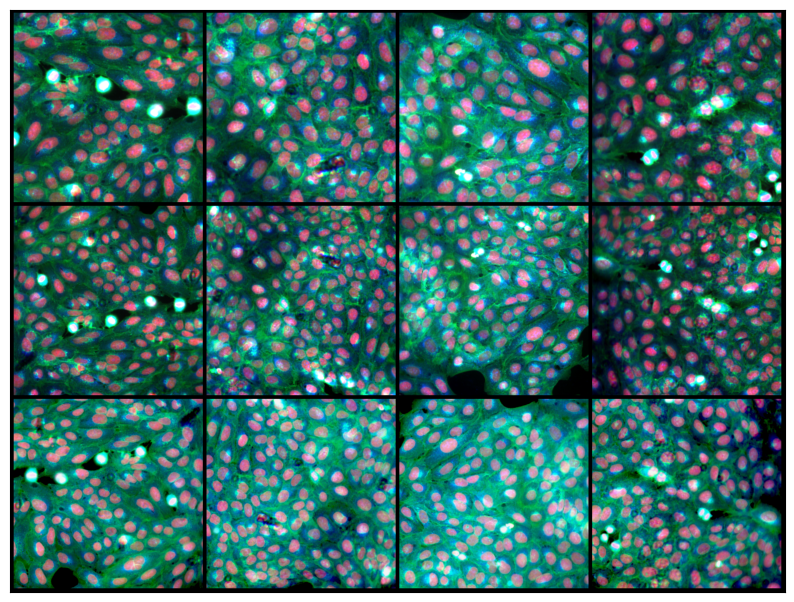

In [349]:
grid = make_grid(
    img[:, :3],
    figsize=(14, 14),
    nrow=4,
    padding=10,
    pad_value=0,
)
show(grid)

In [195]:
grid.shape

torch.Size([3, 3600, 2058])

In [15]:
dataset = SimpleDataset(image_path, transform=trans5)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [16]:
for batch in loader:
    print(batch.shape)
    break

torch.Size([4, 5, 512, 512])


In [15]:
img_encoder = CNNEncoder(
    instance_model_name="vit_base_r50_s16_384",
    target_num=512,
    n_channels=5,
)

In [26]:
img_encoder.to("cuda")

CNNEncoder(
  (backbone): VisionTransformer(
    (patch_embed): HybridEmbed(
      (backbone): ResNetV2(
        (stem): Sequential(
          (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
          (norm): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
        )
        (stages): Sequential(
          (0): ResNetStage(
            (blocks): Sequential(
              (0): Bottleneck(
                (downsample): DownsampleConv(
                  (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (norm): GroupNormAct(
                    32, 256, eps=1e-05, affine=True
                    (drop): Identity()
                    (act): Identity()
                  )
                )
                (conv1): S

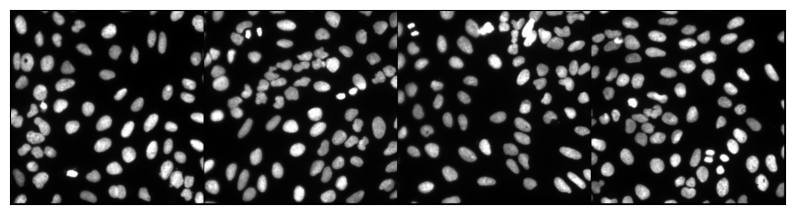

In [83]:
grid = make_grid(batch[:, :1, :, :], figsize=(14, 14))
show(grid)

In [38]:
batch[0, 0]

tensor([[0.3098, 0.3647, 0.4039,  ..., 0.0039, 0.0039, 0.0078],
        [0.2510, 0.3020, 0.3490,  ..., 0.0039, 0.0039, 0.0039],
        [0.1882, 0.2353, 0.2784,  ..., 0.0039, 0.0039, 0.0039],
        ...,
        [0.0118, 0.0118, 0.0118,  ..., 0.0196, 0.0196, 0.0196],
        [0.0157, 0.0157, 0.0157,  ..., 0.0196, 0.0235, 0.0196],
        [0.0118, 0.0157, 0.0118,  ..., 0.0196, 0.0196, 0.0196]])

In [59]:
batch.shape

torch.Size([16, 5, 768, 768])

In [60]:
%timeit transforms.RandomCrop(256)(random_batch).shape

41 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [61]:
%timeit _transforms.RandomCrop(256)(random_batch).shape

28.9 µs ± 687 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [86]:
trans = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(256),
    ImageNormalization(),
)

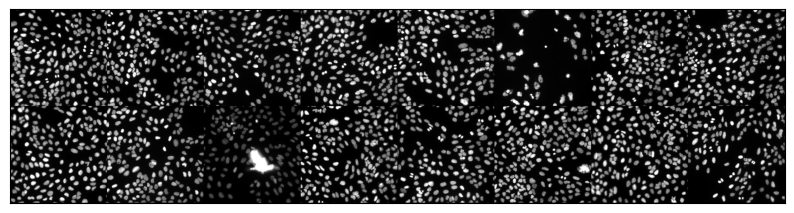

In [84]:
grid = make_grid(batch[:, :1, :, :], figsize=(14, 14))
show(grid)

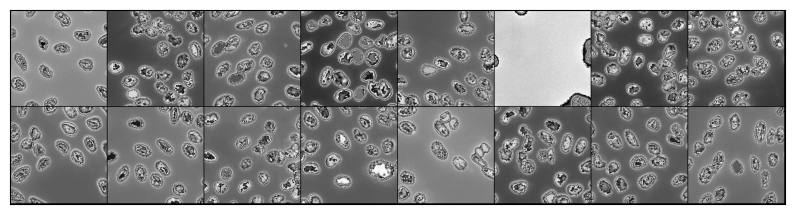

In [87]:
grid = make_grid(trans(batch)[:, :1, :, :], figsize=(14, 14))
show(grid)